```{post} 2023-11-17

```

# [PyTensor](https://github.com/pymc-devs/pytensor) Chat

Ricardo Vieira reached out asking to see if we could chat about egglog and to explore if it could be used inside
of PyTensor for rewriting.

We set up a call and he aggreed to record it, so that we could share anything we talked about with others:


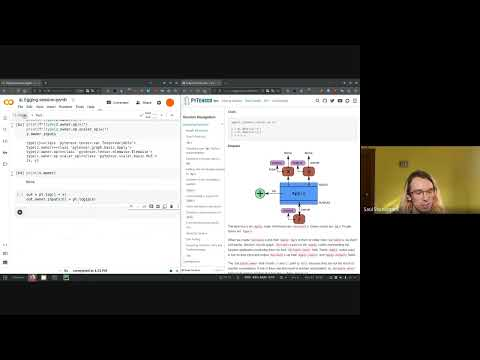

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("8rb841pBhf0")

It was great to get some feedback on the Python bindings and see where the rough patches are. So thank you Ricardo for
being game to explore this together!

Some of the main takeaways for me where:

- Having generic user defined sorts in egglog would be very useful, so that every library like PyTensor doesn't
  have to reimplement collection types for every sort. If we had them, we could say implement a `egglog.std.Tuple`
  class that would work like a tuple, and if you had a user defined `Int` class, you could do `Tuple[Int]`.
- It was interested to see how Ricardo started implementing the Op types at the end, as custom classes, and translating
  the pure functions to them. It's a nice example of how you can write multiple interfaces, depending on the user,
  and right rewrites in whichever you are more comfortable with, as long as you can convert to/from them.

Some further things we could explore in the future are:

- implementing loop nesting in egglog
- converting between the existing PyTensor types and egglog types, in a programatic way, so that we could play with rewrites
  without having to rewrite their whole project.

If anyone else who works on a Python library thinks they could benefit from egglog, or have other questions, feel free
to reach out!

A cleaned up version of the notebook is below:

---


In [ ]:
%%capture
!pip install egglog
!pip install anywidget

In [ ]:
from __future__ import annotations

from functools import partial

from egglog import *

In [ ]:
egraph = EGraph()


@egraph.class_
class Int(Expr):
    def __init__(self, value: i64Like) -> None: ...

    @classmethod
    def var(cls, name: StringLike) -> Int: ...


converter(i64, Int, Int)


@egraph.class_
class IntTuple(Expr):
    def __init__(self, first: Int) -> None: ...

    @classmethod
    def empty(cls) -> IntTuple: ...

    def __add__(self, other: IntTuple) -> IntTuple: ...

    def length(self) -> Int: ...

    def __getitem__(self, i: Int) -> Int: ...


converter(
    tuple,
    IntTuple,
    lambda x: (
        IntTuple(convert(x[0], Int)) + convert(x[1:], IntTuple)
        if len(x) > 1
        else (IntTuple(convert(x[0], Int)) if x else IntTuple.empty())
    ),
)
converter(int, IntTuple, lambda i: IntTuple(Int(i64(i))))
converter(i64, IntTuple, lambda i: IntTuple(Int(i)))
converter(Int, IntTuple, lambda i: IntTuple(i))


@egraph.register
def int_tuple_rules(int_tuple: IntTuple, i: i64, j: i64):
    # Handle tuple concatenation and access
    yield rewrite(IntTuple(i)[0]).to(Int(i))
    yield rewrite((IntTuple(i) + int_tuple)[0]).to(Int(i))
    yield rewrite((IntTuple(i) + int_tuple)[j]).to(int_tuple[Int(j - 1)], j > 0)


Shape = IntTuple


@egraph.class_
class Tensor(Expr):
    def __init__(self, name: StringLike, shape: Shape) -> None: ...

    @property
    def shape(self) -> Shape: ...

    @property
    def ndim(self) -> i64: ...


@egraph.register
def inline_tensor_shape(x: Tensor, name: String, shape: Shape, i: Int):
    yield rewrite(Tensor(name, shape).shape).to(shape)


@egraph.class_
class UnaryOp(Expr):
    def __call__(self, x: Tensor) -> Tensor: ...


@egraph.class_
class BinaryOp(Expr):
    def __call__(self, x: Tensor, y: Tensor) -> Tensor: ...


@egraph.function(cost=1)
def Squeeze(axis: IntTuple) -> UnaryOp: ...


def split_merge_reorder_axis_op(op, x: Tensor, axis: IntTuple, i: i64, j: i64):
    # Split into consecutive axis applications
    yield (rewrite(op(axis=(i, *axis))(x)).to(op(axis=(i,))(op(axis=axis)(x))))
    # Swap consecutive axis applications
    yield (
        rewrite(op(axis=(i,))(op(axis=(j,))(x))).to(
            op(axis=(j - 1,))(op(axis=(i,))(x)),
            i < j,
        )
    )
    yield (
        rewrite(op(axis=(i,))(op(axis=(j,))(x))).to(
            op(axis=(j,))(op(axis=(i + 1,))(x)),
            i > j,
        )
    )
    # Merge from consecutive axis applications
    yield (
        rewrite(op(axis=(i,))(op(axis=(j,))(x))).to(
            op(axis=(i, j))(x),
            i < j,
        )
    )
    yield (
        rewrite(op(axis=(i,))(op(axis=(j, *axis))(x))).to(
            op(axis=(i,) + (j + axis))(x),
            i < j,
        )
    )


@egraph.register
def squeeze_rules(
    x: Tensor,
    axis: IntTuple,
    i: i64,
    j: i64,
):
    yield from split_merge_reorder_axis_op(Squeeze, x, axis, i, j)

    # Squeeze.shape
    yield (rewrite(Squeeze(axis=(i,))(x).shape[j]).to(x.shape[j + 1], i <= j))
    yield (rewrite(Squeeze(axis=(i,))(x).shape[j]).to(x.shape[j], i > j))


@egraph.class_
class OpType(Expr): ...


ScalarAdd = egraph.constant("ScalarAdd", OpType)
ScalarMul = egraph.constant("ScalarMul", OpType)
ScalarDiv = egraph.constant("ScalarDiv", OpType)


@egraph.function(cost=10)
def Reduce(scalar_op: OpType, axis: IntTuple) -> UnaryOp: ...


@egraph.function(cost=5)
def Elemwise(scalar_op: OpType) -> BinaryOp: ...


Mul = Elemwise(ScalarMul)
Div = Elemwise(ScalarDiv)
Sum = partial(Reduce, ScalarAdd)


@egraph.register
def sum_rules(
    x: Tensor,
    y: Tensor,
    z: Tensor,
    i: i64,
    j: i64,
    axis: IntTuple,
    axis2: IntTuple,
    op: OpType,
):
    any_reduce_op = partial(Reduce, op)
    yield from split_merge_reorder_axis_op(any_reduce_op, x, axis, i, j)

    # Introduce shape[i] needed for removing useless reductions
    yield (rule(eq(y).to(any_reduce_op(axis=(i,))(x))).then(x.shape[i]))

    # Remove useless reductions
    yield (rewrite(any_reduce_op(axis=(i,))(x)).to(Squeeze(axis=(i,))(x), eq(x.shape[i]).to(Int(1))))

    # Introduce shape[i] needed for factoring out multiplication/division out of sum
    yield (rule(eq(z).to(Sum(axis=(i,))(Elemwise(op)(x, y)))).then(y.shape[i]))

    # Factor multiplication/division out of sum
    for elemwise_op in (Mul, Div):
        yield (
            rewrite(Sum(axis=(i,))(elemwise_op(x, y))).to(
                elemwise_op(
                    Sum(axis=(i,))(x),
                    Squeeze(axis=(i,))(y),
                ),
                eq(y.shape[i]).to(Int(1)),
            )
        )


x = Tensor("x", (Int.var("x_dim_0"), 5, 7))
y = Tensor("y", (1, 5, 1))
expr = Sum(axis=(0, 2))(Div(x, y))
# expr = Sum(axis=(0, 2))(y)

egraph.register(expr)
# egraph

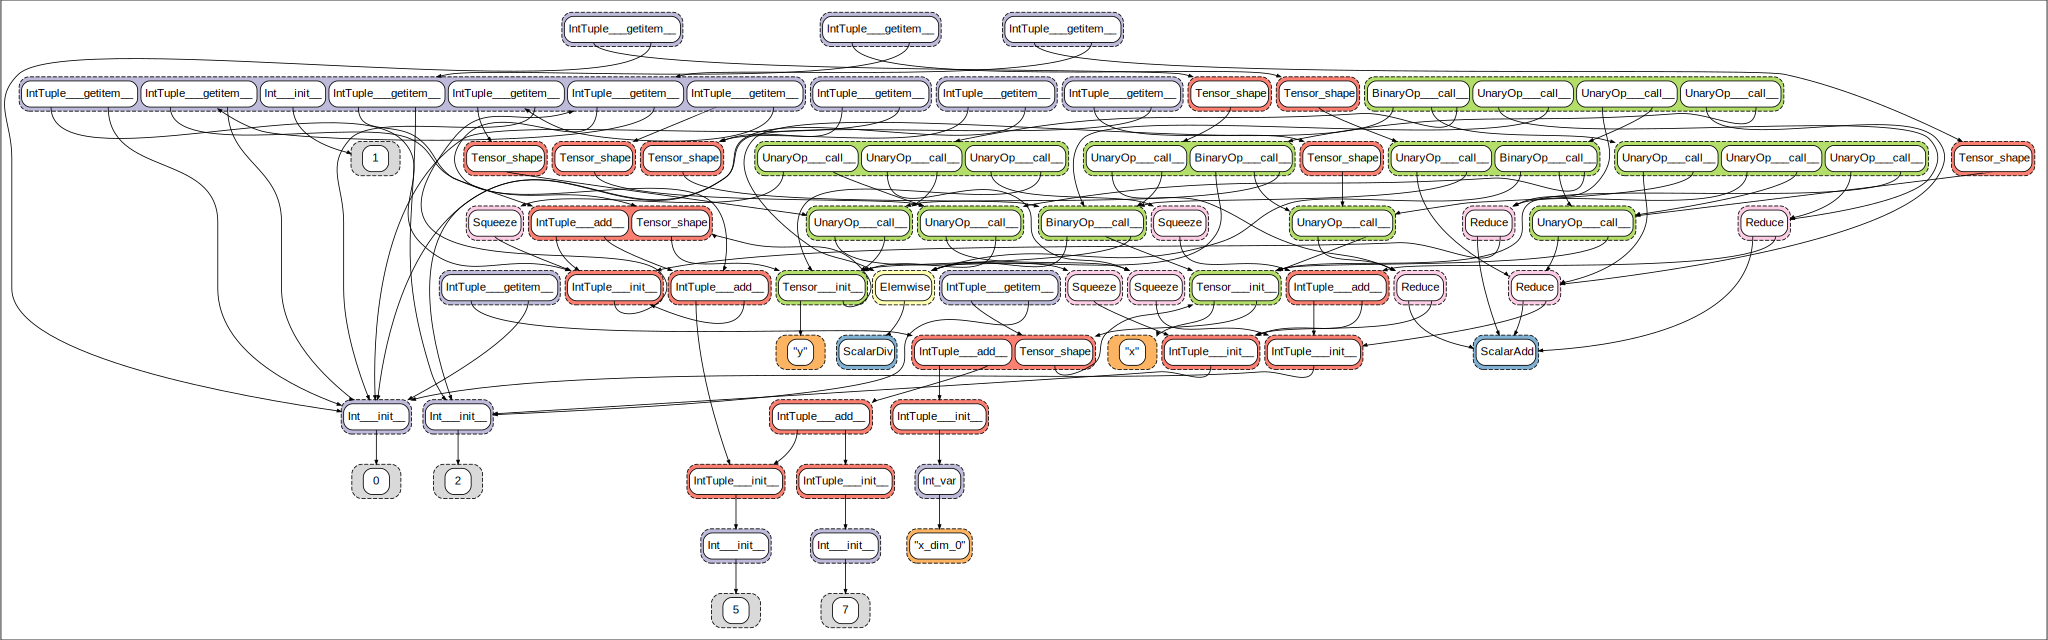

In [ ]:
egraph.run(20)
egraph.display(n_inline_leaves=0)

In [ ]:
egraph.extract(expr)

Reduce(ScalarAdd, IntTuple(Int(0)) + IntTuple(Int(2)))(
    Elemwise(ScalarDiv)(Tensor("x", IntTuple(Int.var("x_dim_0")) + (IntTuple(Int(5)) + IntTuple(Int(7)))), Tensor("y", IntTuple(Int(1)) + (IntTuple(Int(5)) + IntTuple(Int(1)))))
)

In [ ]:
egraph.extract_multiple(expr, 10)

[Elemwise(ScalarDiv)(
     Reduce(ScalarAdd, IntTuple(Int(0)) + IntTuple(Int(2)))(Tensor("x", IntTuple(Int.var("x_dim_0")) + (IntTuple(Int(5)) + IntTuple(Int(7))))),
     Squeeze(IntTuple(Int(0)) + IntTuple(Int(2)))(Tensor("y", IntTuple(Int(1)) + (IntTuple(Int(5)) + IntTuple(Int(1))))),
 ),
 Reduce(ScalarAdd, IntTuple(Int(0)) + IntTuple(Int(2)))(
     Elemwise(ScalarDiv)(Tensor("x", IntTuple(Int.var("x_dim_0")) + (IntTuple(Int(5)) + IntTuple(Int(7)))), Tensor("y", IntTuple(Int(1)) + (IntTuple(Int(5)) + IntTuple(Int(1)))))
 ),
 Reduce(ScalarAdd, IntTuple(Int(0)))(
     Reduce(ScalarAdd, IntTuple(Int(2)))(
         Elemwise(ScalarDiv)(
             Tensor("x", IntTuple(Int.var("x_dim_0")) + (IntTuple(Int(5)) + IntTuple(Int(7)))), Tensor("y", IntTuple(Int(1)) + (IntTuple(Int(5)) + IntTuple(Int(1))))
         )
     )
 ),
 Reduce(ScalarAdd, IntTuple(Int(1)))(
     Reduce(ScalarAdd, IntTuple(Int(0)))(
         Elemwise(ScalarDiv)(
             Tensor("x", IntTuple(Int.var("x_dim_0")) + (Int

In [ ]:
egraph.check(
    eq(Sum(axis=(0, 2))(Div(x, y))).to(
        # Sum(axis=0)(Mul(Sum(axis=0)(x), Squeeze(axis=0)(y)))
        Div(
            Sum(axis=(0, 2))(x),
            Squeeze(axis=(0, 2))(y),
        )
        # Sum(axis=(0,))(Sum(axis=(1, 2))(y))
        # Squeeze(axis=(0, 2))(y)
    )
)